In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# keras functionality
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import (Activation, Add, Average, AvgPool1D, AvgPool2D, BatchNormalization, Concatenate, Conv1D, Conv2D,
                                     Dense, Dropout, Flatten, Input, Lambda, LayerNormalization, MaxPool1D, MaxPool2D, Reshape)

# Read in data

In [2]:
od_feats = np.load('../data/offense_vs_defensive_features.npy')
rb_feats = pd.read_csv('../data/rusher_features.csv').drop(['GameId','PlayId'], axis=1)
game_feats = pd.read_csv('../data/game_situation.csv').drop(['GameId','PlayId'], axis=1)

In [3]:
print(od_feats.shape, rb_feats.shape, game_feats.shape)

(31007, 10, 11, 10) (31007, 42) (31007, 5)


In [4]:
n_cnn_feats = od_feats.shape[3]
n_rb_feats = rb_feats.shape[1]
n_game_feats = game_feats.shape[1]

In [5]:
Yards = pd.read_csv('../data/yard_outcomes.csv')

In [6]:
Yards.head()

,GameId,PlayId,Yards,YardsToTouchdown,YardsToSafety,YardIndex,YardIndexClipped,UnclippedYardIndex
0,2017090700,20170907000118,8,65,35,107,107,107
1,2017090700,20170907000139,3,57,43,102,102,102
2,2017090700,20170907000189,5,35,65,104,104,104
3,2017090700,20170907000345,2,2,98,101,101,101
4,2017090700,20170907000395,7,75,25,106,106,106


In [7]:
min_idx = 71
max_idx = 150
num_classes = max_idx - min_idx + 1

In [8]:
N = Yards.shape[0]
Y = np.zeros((N, num_classes))
for i in range(N):
    index_location = Yards.loc[i, 'YardIndexClipped'] - min_idx
    Y[i, index_location] = 1

# Standardize Features

In [9]:
od_std = (od_feats - od_feats.mean(axis=0))/(od_feats.std(axis=0))
rb_std = ((rb_feats - rb_feats.mean(axis=0))/(rb_feats.std(axis=0))).values
game_std = ((game_feats - game_feats.mean(axis=0))/(game_feats.std(axis=0))).values

# Split data into train/val/test

In [10]:
N = Yards.shape[0]
train_perc = 0.80
val_test_perc = 0.50

train_N = int(N*train_perc)
val_N = int((N-train_N)*val_test_perc)
test_N = int(N-train_N-val_N)
(train_N, val_N, test_N)

(24805, 3101, 3101)

In [11]:
train_indx = np.random.choice(a=Yards.index, size=train_N, replace=False)

remaining_indexes = [x for x in Yards.index if x not in train_indx]
val_indx = np.random.choice(a=remaining_indexes, size=val_N, replace=False)

test_indx = [x for x in remaining_indexes if x not in val_indx]

print(len(train_indx), len(val_indx), len(test_indx))

24805 3101 3101


In [12]:
X_train_od = od_std[train_indx, :, :]
X_val_od = od_std[val_indx, :, :]
X_test_od = od_std[test_indx, :, :]

X_train_rb = rb_std[train_indx, :]
X_val_rb = rb_std[val_indx, :]
X_test_rb = rb_std[test_indx, :]

X_train_game = game_std[train_indx, :]
X_val_game = game_std[val_indx, :]
X_test_game = game_std[test_indx, :]

y_train = Y[train_indx, :]
y_val = Y[val_indx, :]
y_test = Y[test_indx, :]

# Define Model Architecture

In [13]:
K.clear_session()

# input dimension is 10 offensive players x 11 defensive players x n_feats
cnn_input = Input(shape=(10,11,n_cnn_feats))

x = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(cnn_input)
x = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu')(x)
x = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(x)

# pooling is done such that we have aggregated offensive information
# over each of the 11 defensive players. This way we have information
# about defensive players and how they relate to the RB in our last
# block of Convs
a = AvgPool2D(pool_size=(10,1))(x)
a = Lambda(lambda x: x*0.7)(a)
m = MaxPool2D(pool_size=(10,1))(x)
m = Lambda(lambda x: x*0.3)(m)

x = Add()([a, m])
x = Reshape((11,128))(x)

x = BatchNormalization()(x)

x = Conv1D(160, kernel_size=1, strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(96, kernel_size=1, strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(96, kernel_size=1, strides=1, activation='relu')(x)
x = BatchNormalization()(x)

a = AvgPool1D(pool_size=11)(x)
a = Lambda(lambda x: x*0.7)(a)
m = MaxPool1D(pool_size=11)(x)
m = Lambda(lambda x: x*0.3)(m)

x = Add()([a,m])
x = Flatten()(x)

# RB and Game Situation Features
rb_input = Input(shape=(n_rb_feats,))
game_input = Input(shape=(n_game_feats,))

x = Concatenate()([x,rb_input,game_input])

x = Dense(96, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = [cnn_input,rb_input,game_input], outputs = output)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 11, 10)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 11, 128)  1408        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 11, 160)  20640       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 10, 11, 128)  20608       conv2d_1[0][0]                   
______________________________________________________________________________________________

#### Define Callbacks and Early Stopping

In [15]:
def crps(y_true, y_pred):
    N = len(y_true)
    
    num = K.sum(K.sum((K.cumsum(y_pred, axis = 1) - K.cumsum(y_true, axis=1))**2, axis=1), axis=0)
    den = float(199*N)
    loss = num/den
    
    return loss

In [16]:
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
        # we have a train and val tuple
        # both house our features and yards gained
        train_tuple = self.data[0]
        val_tuple = self.data[1]
        
        X_train_od, X_train_rb, X_train_game, y_train = train_tuple[0], train_tuple[1], train_tuple[2], train_tuple[3]
        X_val_od, X_val_rb, X_val_game, y_val = val_tuple[0], val_tuple[1], val_tuple[2], val_tuple[3]
        
        # generate predictions
        train_preds = self.model.predict([X_train_od, X_train_rb, X_train_game]).astype(float)
        val_preds = self.model.predict([X_val_od, X_val_rb, X_val_game]).astype(float)
        
        # calculate crps
        train_crps = crps(y_train, train_preds)
        val_crps = crps(y_val, val_preds)
        
        # store epoch train/val crps results in log
        # will access this information in model.history.history
        logs['train_CRPS'] = train_crps
        logs['val_CRPS'] = val_crps
        
        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)

In [17]:
es = EarlyStopping(monitor='val_CRPS', 
                   mode='min', 
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=20)

es.set_model(model)

metric = Metric(model, [es], [(X_train_od, X_train_rb, X_train_game, y_train), 
                              (X_val_od, X_val_rb, X_val_game, y_val)])

opt = Adam(learning_rate=0.001)

In [18]:
model.compile(optimizer=opt, loss=crps)

In [19]:
n_epochs = 10
batch_size = 64

In [20]:
%%time
model.fit([X_train_od, X_train_rb, X_train_game],
          y_train, 
          epochs=n_epochs,
          batch_size=batch_size,
          verbose=1,
          callbacks=[metric],
          validation_data=([X_val_od, X_val_rb, X_val_game], y_val))

Epoch 1/10
388/388 [==============================] - 26s 58ms/step - loss: 0.0155 - val_loss: 0.0140
Epoch 2/10
388/388 [==============================] - 19s 50ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 3/10
388/388 [==============================] - 21s 53ms/step - loss: 0.0131 - val_loss: 0.0133
Epoch 4/10
388/388 [==============================] - 21s 55ms/step - loss: 0.0129 - val_loss: 0.0133
Epoch 5/10
388/388 [==============================] - 21s 55ms/step - loss: 0.0127 - val_loss: 0.0129
Epoch 6/10
388/388 [==============================] - 21s 55ms/step - loss: 0.0126 - val_loss: 0.0129
Epoch 7/10
388/388 [==============================] - 23s 58ms/step - loss: 0.0125 - val_loss: 0.0128
Epoch 8/10
388/388 [==============================] - 21s 54ms/step - loss: 0.0124 - val_loss: 0.0126
Epoch 9/10
388/388 [==============================] - 22s 56ms/step - loss: 0.0123 - val_loss: 0.0128
Epoch 10/10
388/388 [==============================] - 21s 55ms/step - loss: 0.012

In [21]:
history = model.history.history

train_history = history['train_CRPS']
val_history = history['val_CRPS']

indexes = [x for x in range(len(val_history))]

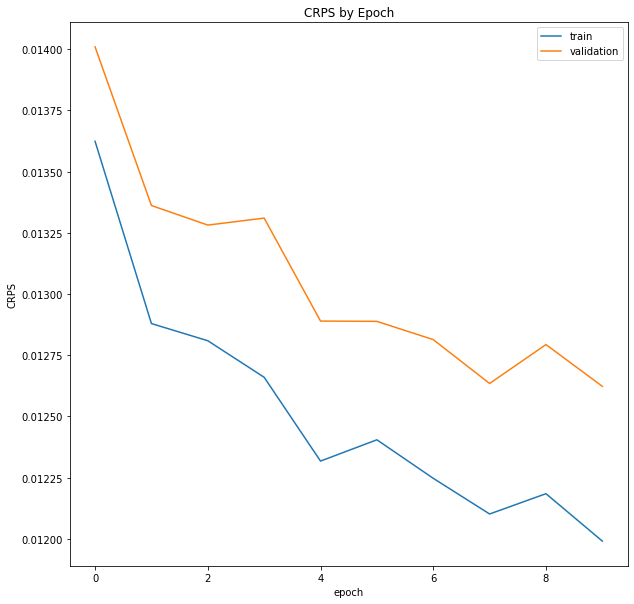

In [22]:
plt.figure(figsize=(10,10))
plt.plot(indexes, train_history)
plt.plot(indexes, val_history)
plt.xlabel('epoch')
plt.ylabel('CRPS')
plt.title('CRPS by Epoch')
plt.legend(['train','validation'])
plt.show()